In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from ts_utils import seasonal_plot, plot_periodogram
from warnings import simplefilter
simplefilter("ignore")

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# Household Power Consumption
Additional explanations
- https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption
- https://machinelearningmastery.com/how-to-load-and-explore-household-electricity-usage-data/

Our Target: 'global_active_power' household global minute-averaged active power (in kilowatt). This represents the power consumed at current time.

In [3]:
df = pd.read_csv("data/household_power_consumption.txt", 
                 sep=";", 
                 low_memory=False, 
                 infer_datetime_format=True, 
                 parse_dates={'date':[0]}, 
                 )

In [4]:
df.head(3)

,date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   date                   datetime64[ns]
 1   Time                   object        
 2   Global_active_power    object        
 3   Global_reactive_power  object        
 4   Voltage                object        
 5   Global_intensity       object        
 6   Sub_metering_1         object        
 7   Sub_metering_2         object        
 8   Sub_metering_3         float64       
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 142.5+ MB


In [6]:
len(df)

2075259

In [7]:
# Duplicates?
len(df) - len(df.drop_duplicates())

0

In [8]:
# Missing values?
df.replace('?', np.nan, inplace=True)
df.isna().sum()

date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

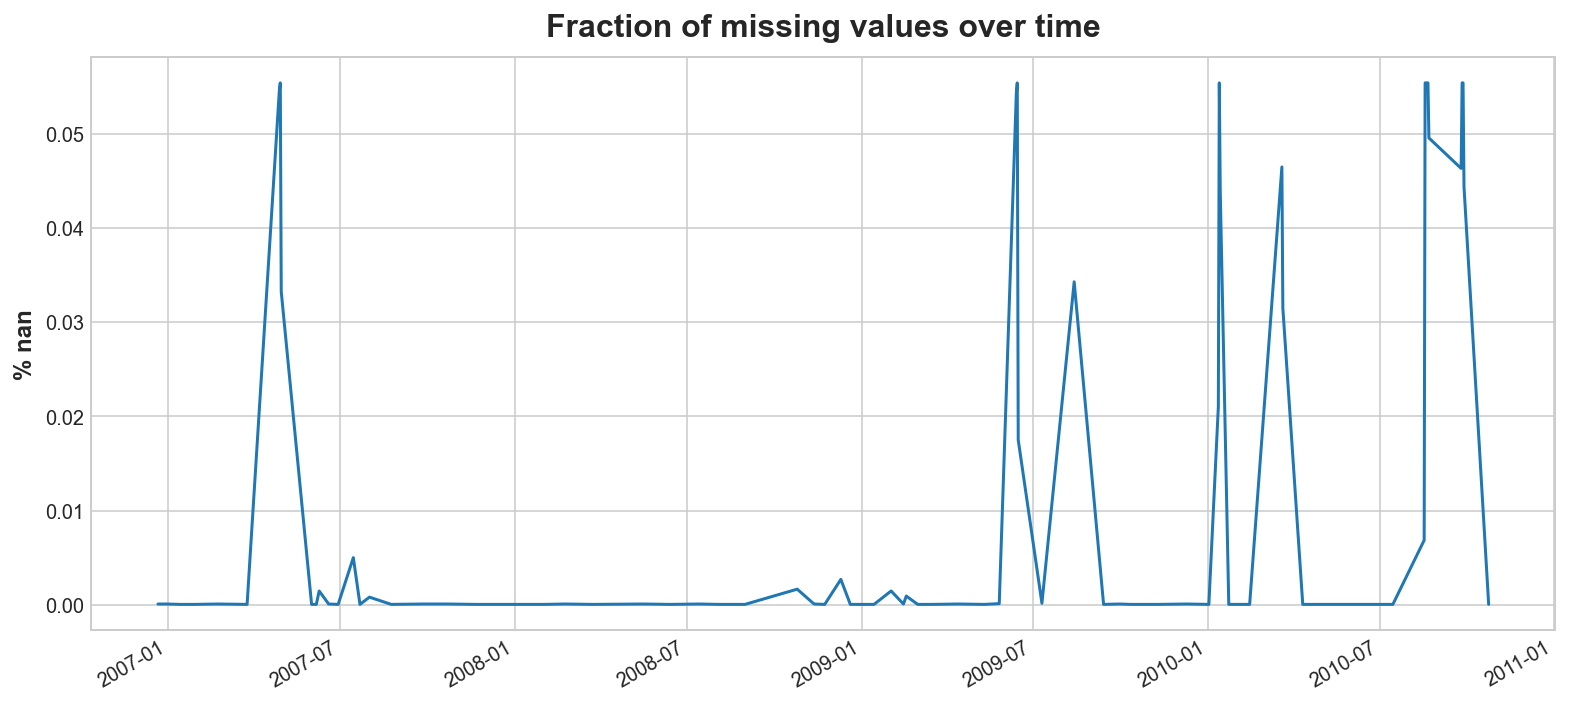

In [9]:
df[df.Global_active_power.isna()].date.value_counts(normalize=True).plot()
plt.title("Fraction of missing values over time")
plt.ylabel("% nan")
plt.show()

From summer 2009 on data contains more days with missing values. How many days are missing completely (in other words, have no data at all)?

In [10]:
sum(df[df.Global_active_power.isna()].date.value_counts() == df.date.value_counts().max())

9

How many days do we have?

In [11]:
len(df.date.unique())

1442

Since we want to predict consumption per day (not per minute), we'll replace missing data for Global_active_power with the mean after grouping by day. Specifically we'll backward fill them.

In [12]:
df.Global_active_power = df.Global_active_power.astype(float)
y = df[["date", "Global_active_power"]].groupby("date").mean()
y.Global_active_power.bfill(inplace=True)
y.index = pd.DatetimeIndex(y.index)

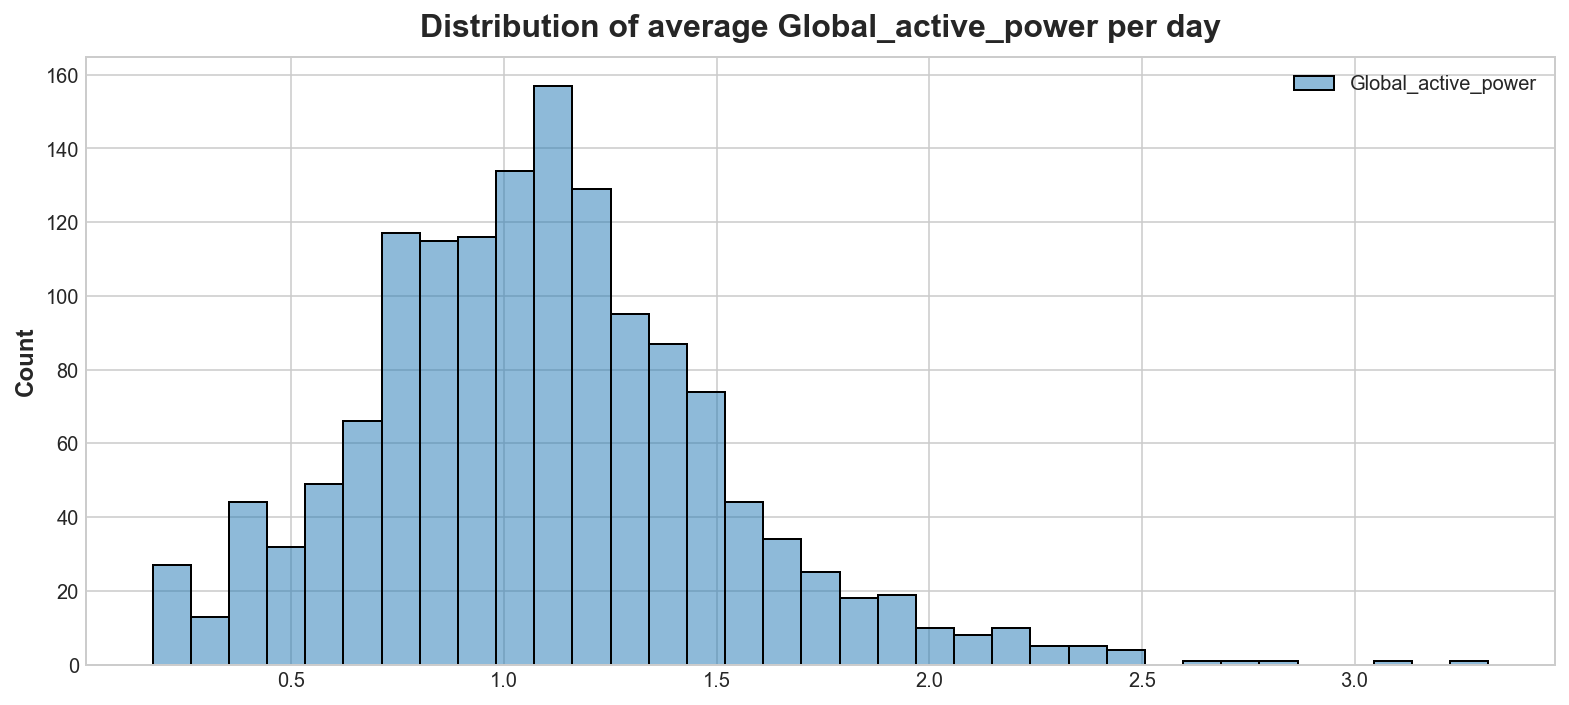

In [13]:
sns.histplot(y).set(title="Distribution of average Global_active_power per day");plt.show()

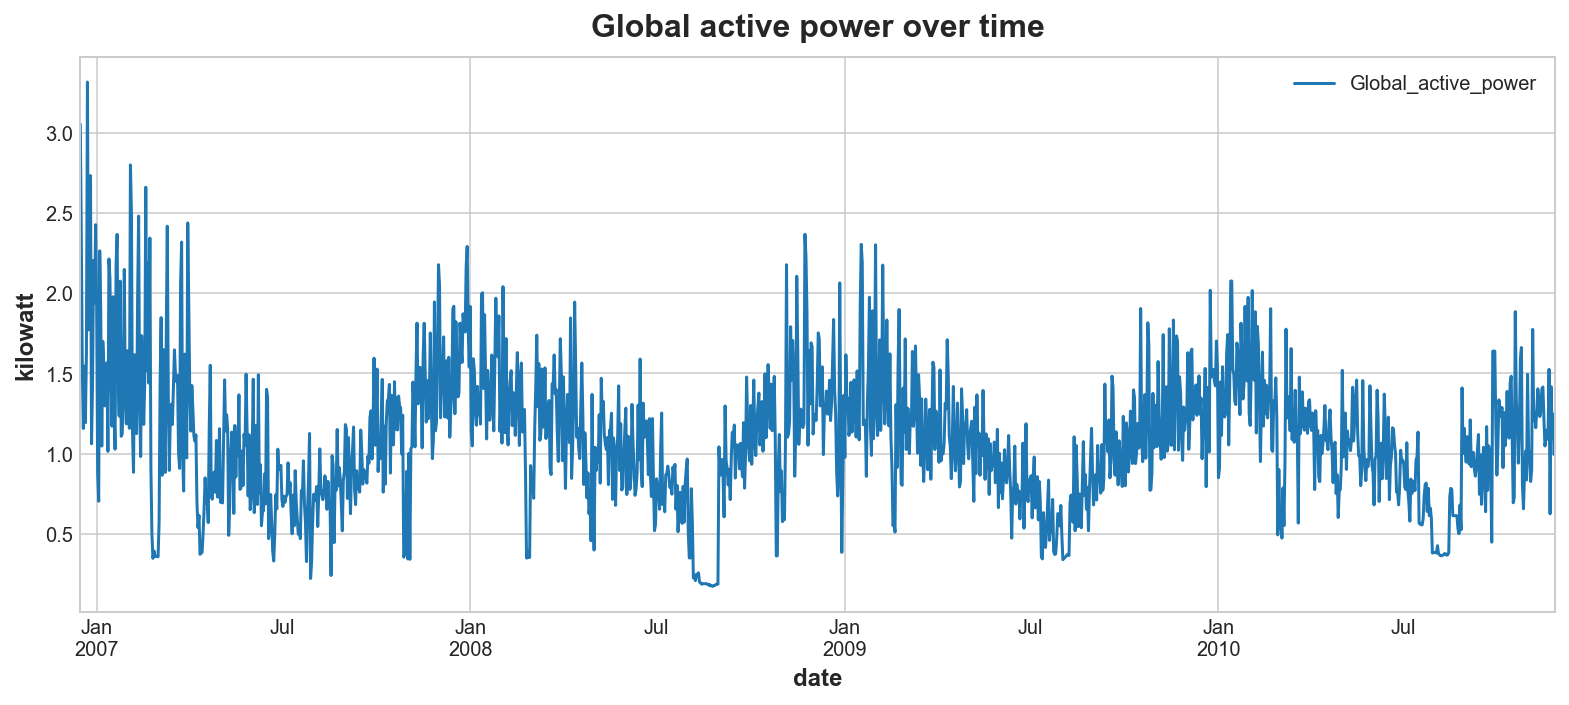

In [14]:
y.plot();plt.title("Global active power over time"); plt.ylabel("kilowatt"); plt.show()

On the first glance we see already some nice seasonal patterns.

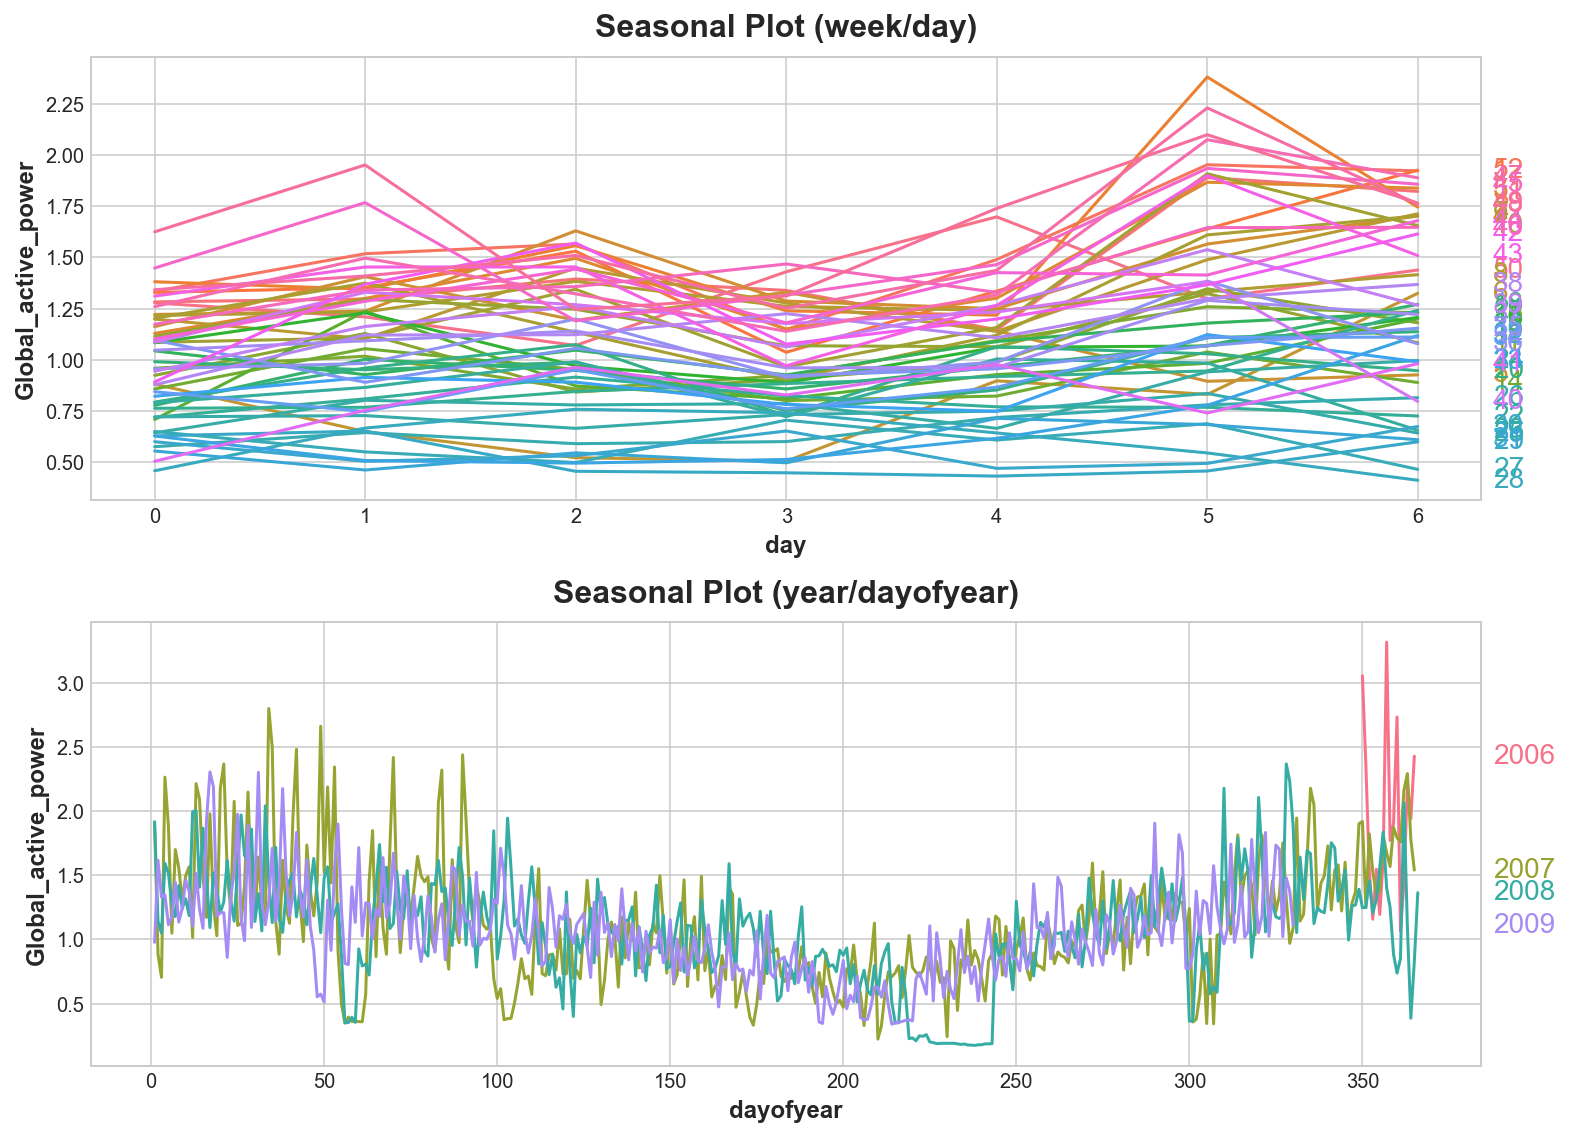

In [15]:
# Check all, ignore last year
X_train = y.iloc[:-365].copy()
# days within a week
X_train["day"] = X_train.index.dayofweek  # the x-axis (freq)
X_train["week"] = X_train.index.week  # the seasonal period (period)

# days within a year
X_train["dayofyear"] = X_train.index.dayofyear
X_train["year"] = X_train.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 8))
seasonal_plot(X_train, y="Global_active_power", period="week", freq="day", ax=ax0)
seasonal_plot(X_train, y="Global_active_power", period="year", freq="dayofyear", ax=ax1)
plt.show()

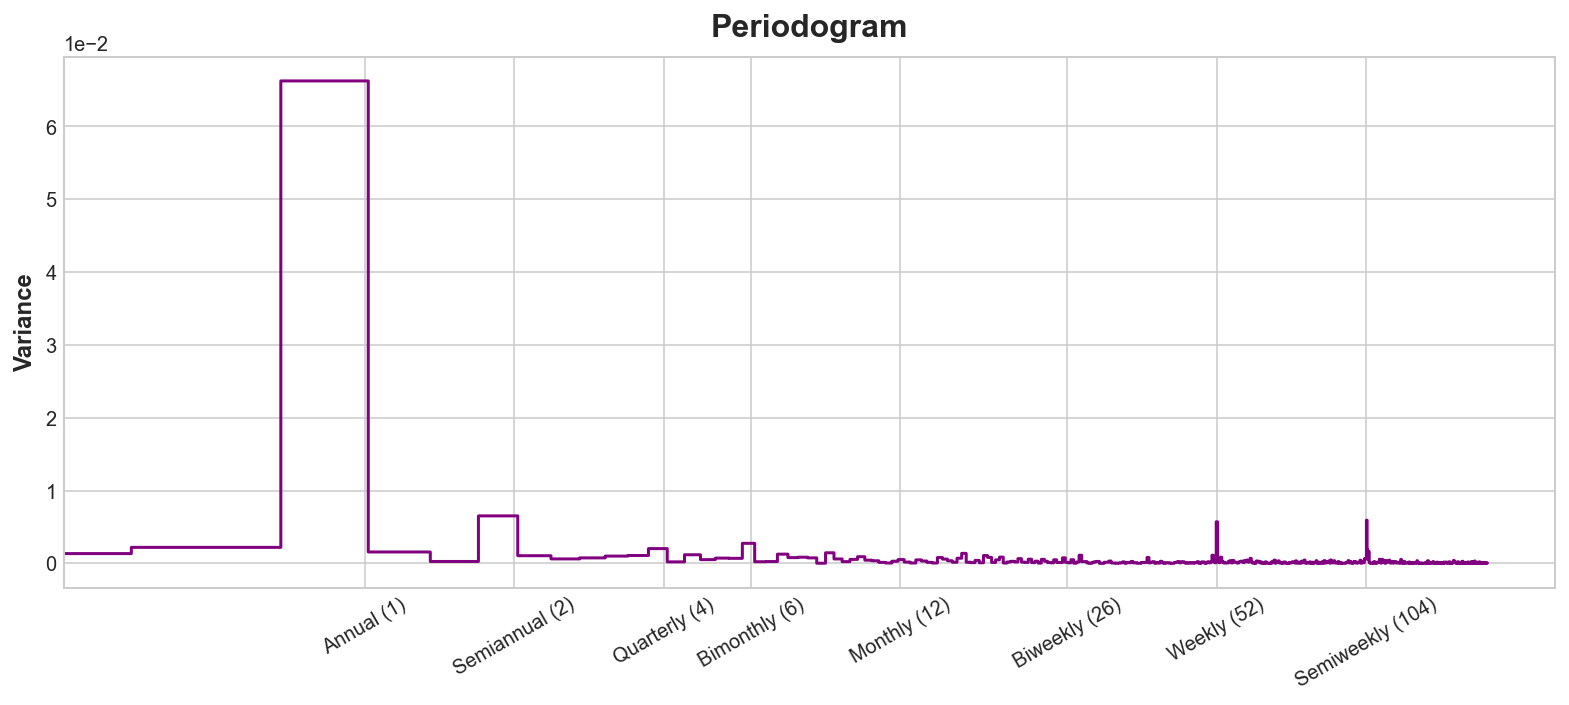

In [39]:
plot_periodogram(X_train.Global_active_power)
plt.show()

Since there's quite some variance at the beginning, the diagram is hard to read. But it looks like the graph goes down somewhere between 6 and 12 and a bit behind. Let's try 12 fourier pairs then.

In [17]:

fourier = CalendarFourier(freq="A", order=12)  # 12 sin/cos pairs for "A"nnual seasonality
# semiannual (2) + quarterly (4) ~ 6 sin/cos pairs per year


dp = DeterministicProcess(
    index=X_train.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_train_dp = dp.in_sample() 
X_train_dp.head(3)

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)",...,"sin(8,freq=A-DEC)","cos(8,freq=A-DEC)","sin(9,freq=A-DEC)","cos(9,freq=A-DEC)","sin(10,freq=A-DEC)","cos(10,freq=A-DEC)","sin(11,freq=A-DEC)","cos(11,freq=A-DEC)","sin(12,freq=A-DEC)","cos(12,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2006-12-16,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.271958,0.962309,...,-0.806480,-0.591261,-0.615285,-0.788305,-0.377708,-0.925925,-0.111659,-0.993747,0.162807,-0.986658
2006-12-17,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.255353,0.966848,...,-0.880012,-0.474951,-0.729558,-0.683919,-0.530730,-0.847541,-0.296713,-0.954967,-0.043022,-0.999074
2006-12-18,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.238673,0.971100,...,-0.936881,-0.349647,-0.826354,-0.563151,-0.668064,-0.744104,-0.471160,-0.882048,-0.247022,-0.969010


In [18]:
X_train_dp.index.max()

Timestamp('2009-11-26 00:00:00')

In [19]:
y_train = y.iloc[:-365].copy()
y_test = y[y.index > y_train.index.max()]

In [20]:

model = LinearRegression(fit_intercept=False)
model.fit(X_train_dp, y_train)

LinearRegression(fit_intercept=False)

Text(0, 0.5, 'kilowatt')

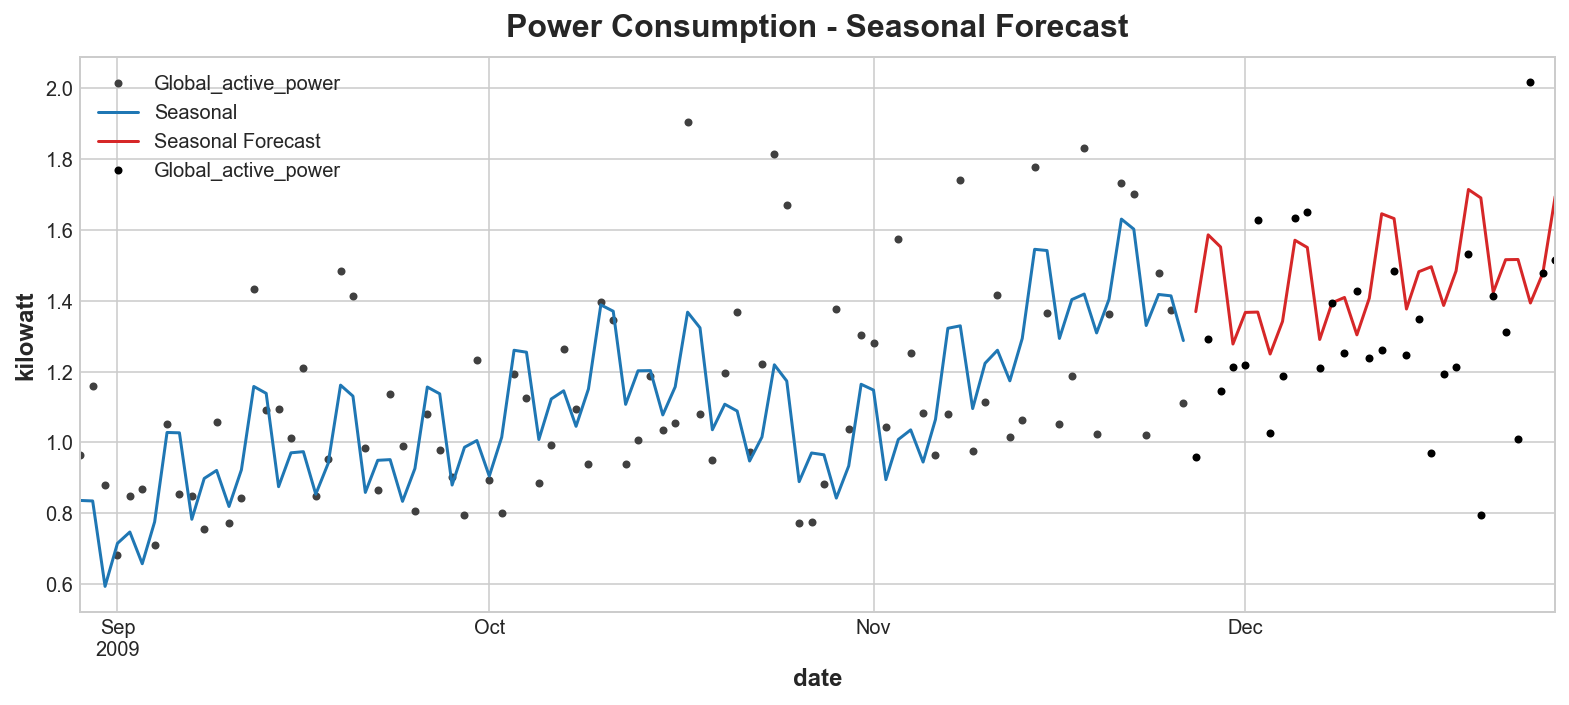

In [40]:
y_pred = pd.Series([i for i in np.squeeze(model.predict(X_train_dp))], index=y_train.index)

forecast_n_days = 30
forecast_index = pd.date_range(y_train.index.max(), periods=forecast_n_days+1).tolist()[1:]

X_fore = dp.out_of_sample(steps=forecast_n_days,forecast_index=forecast_index)
y_fore = pd.Series([i for i in np.squeeze(model.predict(X_fore))], index=X_fore.index)

last_n_days = 90 # for zooming in
ax = y_train.iloc[-last_n_days:].plot(color='0.25', style='.', title="Power Consumption - Seasonal Forecast")
ax = y_pred.iloc[-last_n_days:].plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
ax = y_test.iloc[:forecast_n_days].plot(ax=ax, style='.', color="black")
_ = ax.legend()
plt.ylabel("kilowatt")

In [41]:
# RMSE
mean_squared_error(y_true=y_test.iloc[:forecast_n_days], y_pred=y_fore, squared=False)

0.3070453892863619

In [42]:
# MAPE
mean_absolute_percentage_error(y_true=y_test.iloc[:forecast_n_days], y_pred=y_fore)

0.2029232755162716